# Introducción

## Detección de mensajes spam
Aprendizaje automático (ML) para diferenciar entre mensajes legítimos y spam.

Pasos que vamos a seguir:

* Pasar el texto a minúsculas
* Tokenizar
* Eliminar puntuación
* Eliminar palabras vacías
* Lematizar

Después de eso, "vectorizaremos" nuestros datos en un conjunto de números para que los modelos de aprendizaje automático puedan aprender de ellos.

* Vectorización (TfidfVectorizer)

## Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

## Los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IA - Programa Posgrado/Lesson01/nlp - SPAM text message data.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Tenemos un conjunto de datos simple con 5572 observaciones sin **valores faltantes**. También tenemos una característica o feature **(Message)** y un objetivo **(Category)**

<Axes: xlabel='Category', ylabel='count'>

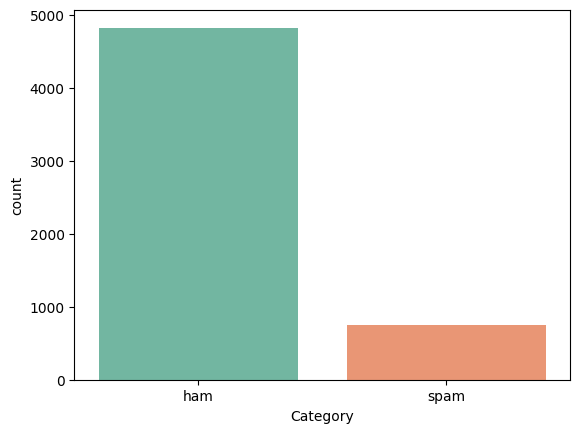

In [ ]:
sns.countplot(x="Category",data=data, palette="Set2")

Podemos ver claramente que la mayoría de nuestros mensajes son ham, es decir, mensajes legítimos. Esto significa que nuestro conjunto de datos está desequilibrado, pero tiene sentido porque la mayoría de los mensajes en general son **mensajes ham**. Sin embargo, más adelante equilibraremos este conjunto de datos.

## Limpieza y preprocesamiento de datos

El preprocesamiento de datos de texto constituye una fase preliminar vital en el procesamiento del lenguaje natural (PLN). Su esencia radica en eliminar perturbaciones, irregularidades y contenidos superfluos del texto, mejorando así la integridad de los datos para su posterior análisis.

### Eliminar puntuación y palabras vacías (Stopwords)

In [ ]:
def cleaning (text):
    text = text.lower()
    text =  re.sub(r'@\S+', '',text)
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

In [ ]:
data["Message"]=data["Message"].apply(cleaning)

### Lematización (Lemmatization)

La lematización sirve como un método de preprocesamiento de texto dentro del ámbito de los modelos de procesamiento del lenguaje natural. Su propósito es deconstruir las palabras hasta su raíz fundamental, facilitando el reconocimiento de semejanzas y similitudes.

In [ ]:
def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['Message'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    data=data.drop("Message",axis=1)
    return data

In [ ]:
data = lemm(data)

### Codificación (Encoding)

No vamos a dejar el objetivo **Category** como un tipo de objeto porque no podemos introducirlo en modelos de aprendizaje automático, para eso usaremos un mapa para codificar sus valores.

In [ ]:
mesg = {"ham":0,"spam":1}
data["Category"]=data["Category"].map(mesg)

## División de datos

### Sobremuestreo (OverSampling)

Vamos a equilibrar nuestro conjunto de datos con un método simple: vamos a crear algunas muestras para la clase 'spam' para que tenga el mismo tamaño que la clase 'ham'. Este método se llama **Sobremuestreo**.

In [ ]:
clas0,clas1=data["Category"].value_counts()
df0=data[data["Category"]==0]
df1=data[data["Category"]==1]
df1=df1.sample(clas0, replace=True)
data = pd.concat([df0, df1])

In [ ]:
labels = data["Category"]
data = data["text"]
labels.value_counts()

0    4825
1    4825
Name: Category, dtype: int64

Ahora dividimos los datos en conjuntos de entrenamiento y prueba para que podamos ajustar y evaluar nuestro modelo correctamente.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

## Extracción de características( Feature Extraction)

### TF-ID Vectoriser

La vectorización con TF-IDF (Term Frequency-Inverse Document Frequency) es un método en NLP que convierte texto a formato numérico y suele tener un buen rendimiento en la detección de spam porque tiene en cuenta la importancia de las palabras en función de su frecuencia en el documento y su rareza en todo el corpus. Esto puede ayudar a distinguir las palabras relevantes de las comunes que podrían no contribuir mucho a la tarea, lo que podría conducir a una mejor separación entre los mensajes legítimos y el spam.

In [ ]:
tfid = TfidfVectorizer()
X_train = tfid.fit_transform(X_train)
X_test = tfid.transform(X_test)

## Modelos de entrenamiento

Finalmente, aplicamos distintos modelos a los datos ya preparados.

### LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)
print(accuracy_score(preds,y_test))

0.9818652849740933


### Decision Tree

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
preds = tree.predict(X_test)
print(accuracy_score(preds,y_test))

0.9813471502590674


### Random Forest

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
preds = forest.predict(X_test)
print(accuracy_score(preds,y_test))

0.9994818652849741


### LightGBM

In [ ]:
clf = ltb.LGBMClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(preds,y_test))

[LightGBM] [Info] Number of positive: 3880, number of negative: 3840
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11814
[LightGBM] [Info] Number of data points in the train set: 7720, number of used features: 739
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502591 -> initscore=0.010363
[LightGBM] [Info] Start training from score 0.010363
0.9937823834196892


### Naive Bayes

Tenga en cuenta que vamos a convertir X_train y X_test en matrices porque Naive Bayes no admite datos dispersos creados por TFidVectoriser.

In [ ]:
naive = GaussianNB()
naive.fit(X_train.toarray(), y_train)
preds = naive.predict(X_test.toarray())
print(accuracy_score(preds,y_test))

0.9404145077720207


### Support Vector Machine

In [ ]:
SVM = SVC()
SVM.fit(X_train, y_train)
preds = SVM.predict(X_test)
print(accuracy_score(preds,y_test))

0.9984455958549223
